In [100]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import jinja2
import matplotlib.dates as mdates


In [101]:
# Read Data
df=pd.read_csv('monatszahlen2307_verkehrsunfaelle_10_07_23_nosum.csv')

In [102]:
# Convert German Feature Names to English
column_name_mapping = {
    "MONATSZAHL": "Category",
    "AUSPRAEGUNG": "Accident-type",
    "JAHR": "Year",
    "MONAT": "Month",
    "WERT": "Value",
    "VORJAHRESWERT": "Previous_Year_Value",
    "VERAEND_VORMONAT_PROZENT": "Change_From_Previous_Month_Percentage",
    "VERAEND_VORJAHRESMONAT_PROZENT": "Change_From_Previous_Year_Month_Percentage",
    "ZWOELF_MONATE_MITTELWERT": "Twelve_Month_Average"
}
df=df.rename(columns=column_name_mapping)

In [103]:
# Explore Data Only Before 2021
df = df[df['Year'] < 2021]

In [104]:
# From "Convert German feature names to English" segment
# you can see that some features are computed from "Value"
# and more features need to be computed from Value in the future
# so we don't need to study these features here for now

columns_to_exclude = ['Previous_Year_Value', 'Change_From_Previous_Month_Percentage', 
                      'Change_From_Previous_Year_Month_Percentage', 'Twelve_Month_Average']
df = df.drop(columns=[col for col in columns_to_exclude if col in df.columns])


In [105]:
# Define Category-Accident Group
unique_combinations = df[['Category', 'Accident-type']].drop_duplicates()

In [75]:
# Validate Unique Monthly Values for Each Category-Accident Group
for index, row in unique_combinations.iterrows():
    filtered_data = df[(df['Category'] == row['Category']) & (df['Accident-type'] == row['Accident-type'])]
    value_counts = filtered_data.groupby('Month')['Value'].nunique()
    
    if (value_counts > 1).any():
        print(f"Category: {row['Category']}, Accident-type: {row['Accident-type']} - Some 'Month' values have multiple 'Value' values")
    else:
        print(f"Category: {row['Category']}, Accident-type: {row['Accident-type']} - Each 'Month' has only one 'Value'")


# It can also be seen here that some Categories correspond to two Accident-types 
# and some to three.


Category: Alkoholunfälle, Accident-type: insgesamt - Each 'Month' has only one 'Value'
Category: Alkoholunfälle, Accident-type: Verletzte und Getötete - Each 'Month' has only one 'Value'
Category: Fluchtunfälle, Accident-type: insgesamt - Each 'Month' has only one 'Value'
Category: Fluchtunfälle, Accident-type: Verletzte und Getötete - Each 'Month' has only one 'Value'
Category: Verkehrsunfälle, Accident-type: insgesamt - Each 'Month' has only one 'Value'
Category: Verkehrsunfälle, Accident-type: mit Personenschäden - Each 'Month' has only one 'Value'
Category: Verkehrsunfälle, Accident-type: Verletzte und Getötete - Each 'Month' has only one 'Value'


In [76]:
# Check Sorted Month Range for Each Category-Accident Group
for _, row in unique_combinations.iterrows():
    # Filter and sort the data by 'Month' for the current combination
    filtered_data = df[(df['Category'] == row['Category']) & (df['Accident-type'] == row['Accident-type'])]
    sorted_data = filtered_data.sort_values(by='Month')

    # Extract the minimum and maximum month values for each sorted group
    min_month = sorted_data['Month'].iloc[0]
    max_month = sorted_data['Month'].iloc[-1]
    
    print(f"Category: {row['Category']}, Accident-type: {row['Accident-type']}, Sorted Month Range: {min_month} to {max_month}")


Category: Alkoholunfälle, Accident-type: insgesamt, Sorted Month Range: 200001 to 202012
Category: Alkoholunfälle, Accident-type: Verletzte und Getötete, Sorted Month Range: 200001 to 202012
Category: Fluchtunfälle, Accident-type: insgesamt, Sorted Month Range: 200001 to 202012
Category: Fluchtunfälle, Accident-type: Verletzte und Getötete, Sorted Month Range: 200001 to 202012
Category: Verkehrsunfälle, Accident-type: insgesamt, Sorted Month Range: 200001 to 202012
Category: Verkehrsunfälle, Accident-type: mit Personenschäden, Sorted Month Range: 200001 to 202012
Category: Verkehrsunfälle, Accident-type: Verletzte und Getötete, Sorted Month Range: 200001 to 202012


In [77]:
# 1. "Check for Duplicate rows": 
#   Confirms that there are no duplicate rows in the dataset.
# 2. "Validate Unique Monthly Values for Each Category-Accident Group": 
#   Ensures that for each group and each timestamp, there are no multiple 'Value' entries.
# 3. "Check Sorted Month Range for Each Category-Accident Group": 
#   Verifies that the timestamp range for each group is consistent

# Final Conclusion: 
# The data quality is satisfactory
# indicating that the timestamp range for each group is consistent and timestamp values are unique
# with each timestamp uniquely corresponding to a single 'Value'.


In [78]:
# Missing Value Report
missing_values = df.isnull().sum()
total_rows = len(df)
missing_percentage = (missing_values / total_rows) * 100
missing_report = pd.DataFrame({
    'Column Name': missing_values.index,
    'Missing Values': missing_values.values,
    'Missing Percentage': missing_percentage.values
})
print("Missing Values Report:")
print(missing_report)

Missing Values Report:
     Column Name  Missing Values  Missing Percentage
0       Category               0                 0.0
1  Accident-type               0                 0.0
2           Year               0                 0.0
3          Month               0                 0.0
4          Value               0                 0.0


In [79]:
# Accident Type Comparison Analysis


# Analyze each category for accident type comparisons
for category in df['Category'].unique():
    accident_types = df[df['Category'] == category]['Accident-type'].unique()

    for i in range(len(accident_types)):
        for j in range(i + 1, len(accident_types)):
            accident_type_1 = accident_types[i]
            accident_type_2 = accident_types[j]

            greater_count, less_count, equal_count = 0, 0, 0
            category_months = df[df['Category'] == category]['Month'].unique()

            for month in category_months:
                value_type_1 = df[(df['Category'] == category) &
                                          (df['Accident-type'] == accident_type_1) &
                                          (df['Month'] == month)]['Value'].max()
                value_type_2 = df[(df['Category'] == category) &
                                          (df['Accident-type'] == accident_type_2) &
                                          (df['Month'] == month)]['Value'].max()

                if value_type_1 > value_type_2:
                    greater_count += 1
                elif value_type_1 < value_type_2:
                    less_count += 1
                else:
                    equal_count += 1

            print(f"In category '{category}', comparing '{accident_type_1}' vs '{accident_type_2}':")
            print(f"Number of months greater: {greater_count}")
            print(f"Number of months less: {less_count}")
            print(f"Number of months equal: {equal_count}\n")

# Conclusion
# In the category 'Verkehrsunfälle', as understood by the literal meaning, the values for 'mit Personenschäden' 
# should be less than or equal to those for 'Verletzte und Getötete'. 
# However, the last part of report indicates that 
# there are three months where 'mit Personenschäden' has greater values. 
# This discrepancy could be due to errors in data collection or entry.

# Across all categories, the values for 'insgesamt' should be greater than or equal to other accident types. 
# The report confirms this observation, aligning with the expected data consistency.

In category 'Alkoholunfälle', comparing 'insgesamt' vs 'Verletzte und Getötete':
Number of months greater: 252
Number of months less: 0
Number of months equal: 0

In category 'Fluchtunfälle', comparing 'insgesamt' vs 'Verletzte und Getötete':
Number of months greater: 252
Number of months less: 0
Number of months equal: 0

In category 'Verkehrsunfälle', comparing 'insgesamt' vs 'mit Personenschäden':
Number of months greater: 252
Number of months less: 0
Number of months equal: 0

In category 'Verkehrsunfälle', comparing 'insgesamt' vs 'Verletzte und Getötete':
Number of months greater: 252
Number of months less: 0
Number of months equal: 0

In category 'Verkehrsunfälle', comparing 'mit Personenschäden' vs 'Verletzte und Getötete':
Number of months greater: 3
Number of months less: 247
Number of months equal: 2



In [83]:
# Correlation Matrix Visualization

# Generate correlation matrix
start_date = 200012  
end_date = 202012 
df_filtered = df[(df['Month'] >= start_date) & (df['Month'] <= end_date)]
pivot_table = df_filtered.pivot_table(index='Month', columns=['Category', 'Accident-type'], values='Value')
correlation_matrix = pivot_table.corr()

# Prepare new column labels
new_columns = []
seen = set()
for col in correlation_matrix.columns:
    col = ' '.join(col).strip() if isinstance(col, tuple) else col
    if col not in seen:
        new_columns.append(col)
        seen.add(col)
    else:
        new_columns.append('')

# Update matrix with new labels
correlation_matrix.columns = new_columns
correlation_matrix.index = new_columns

# Style and display the matrix
styled_df = correlation_matrix.style.background_gradient(cmap='Reds') \
                  .set_properties(**{'text-align': 'center', 'font-size': '10pt'}) \
                  .set_table_styles([
                      {'selector': 'th',
                       'props': [('font-size', '10pt'), ('background-color', '#4f4f4f'), ('color', 'white'), ('border', '1px solid #dcdcdc')]}
                  ])

styled_df


,Alkoholunfälle Verletzte und Getötete,Alkoholunfälle insgesamt,Fluchtunfälle Verletzte und Getötete,Fluchtunfälle insgesamt,Verkehrsunfälle Verletzte und Getötete,Verkehrsunfälle insgesamt,Verkehrsunfälle mit Personenschäden
Alkoholunfälle Verletzte und Getötete,1.000000,0.833564,0.606324,0.204452,0.616973,0.129395,0.602501
Alkoholunfälle insgesamt,0.833564,1.000000,0.522424,0.188649,0.528615,0.105136,0.491359
Fluchtunfälle Verletzte und Getötete,0.606324,0.522424,1.000000,0.592719,0.822223,0.560023,0.815691
Fluchtunfälle insgesamt,0.204452,0.188649,0.592719,1.000000,0.601735,0.858565,0.602286
Verkehrsunfälle Verletzte und Getötete,0.616973,0.528615,0.822223,0.601735,1.000000,0.662348,0.982281
Verkehrsunfälle insgesamt,0.129395,0.105136,0.560023,0.858565,0.662348,1.000000,0.657314
Verkehrsunfälle mit Personenschäden,0.602501,0.491359,0.815691,0.602286,0.982281,0.657314,1.000000


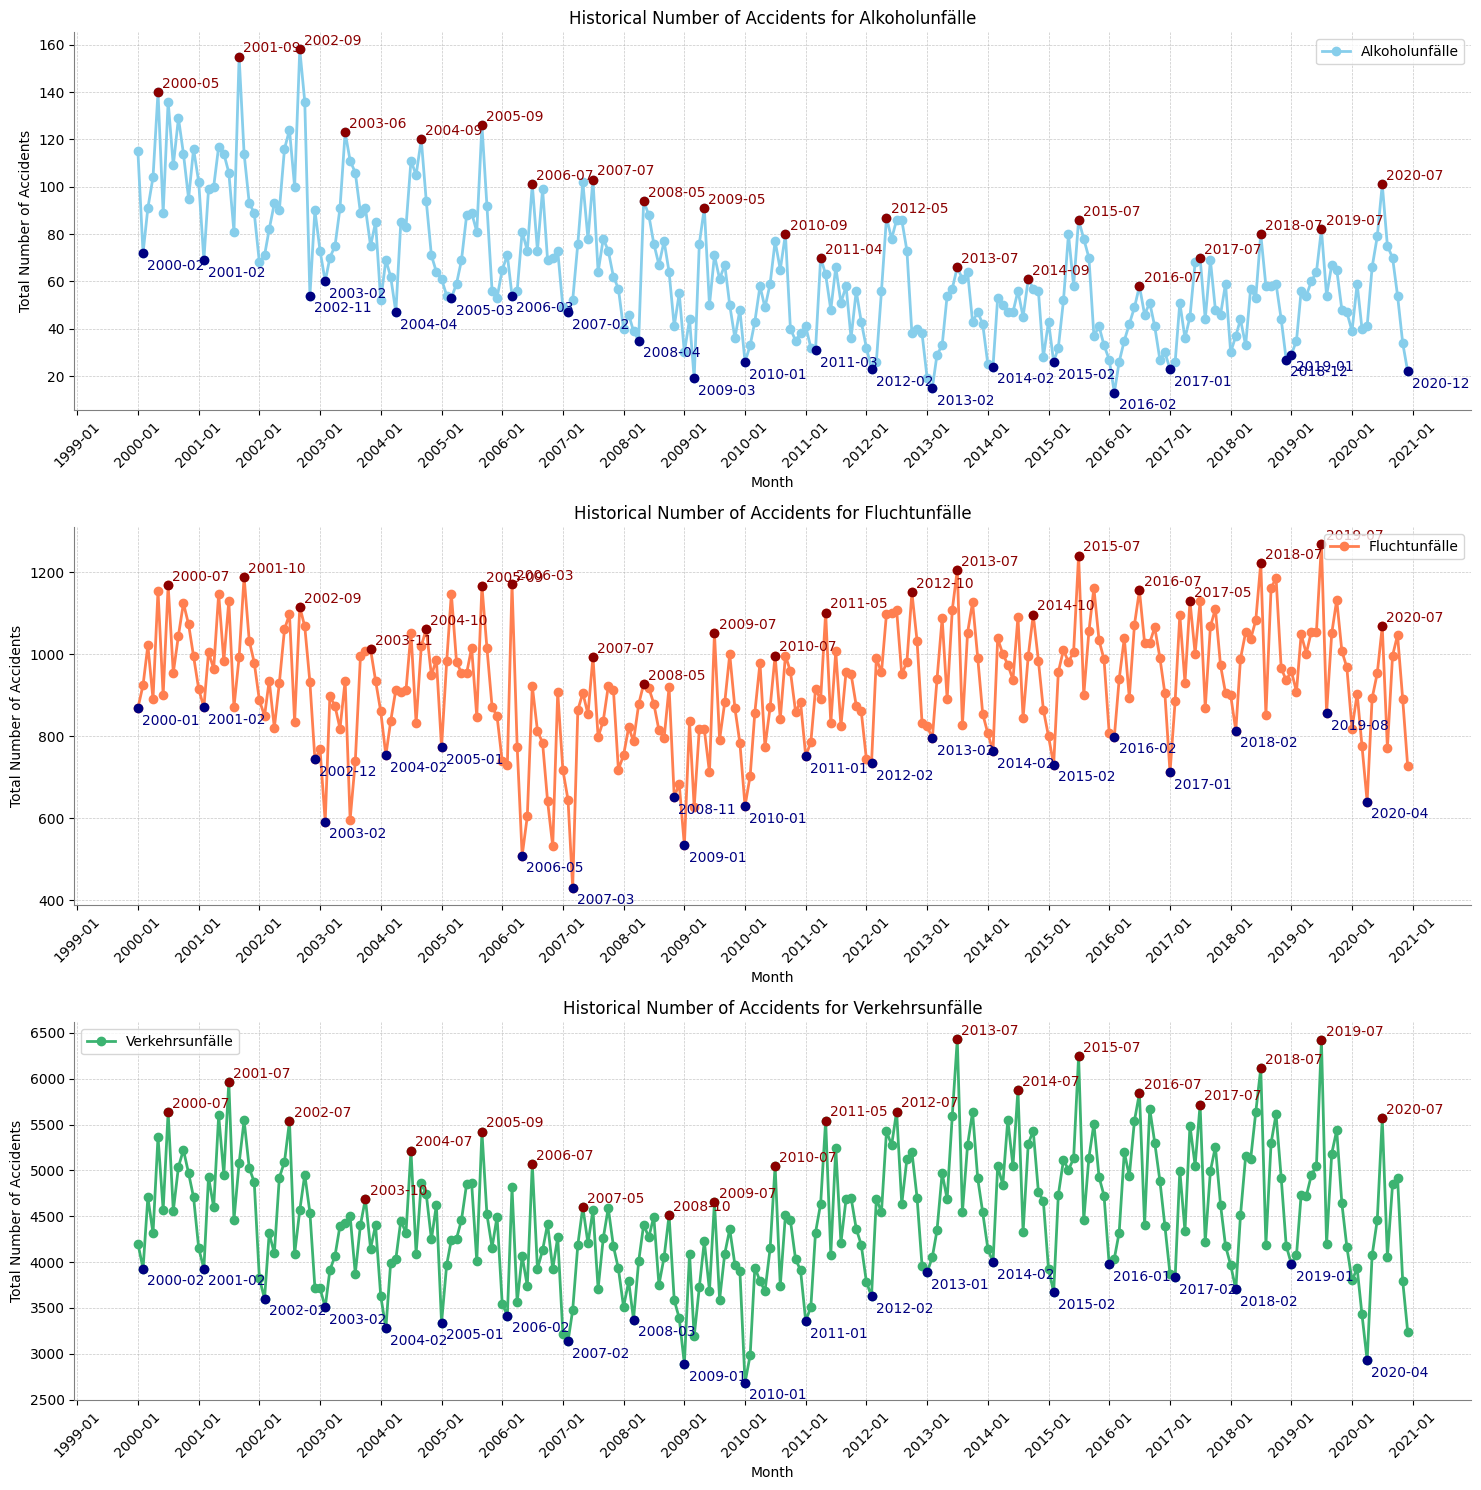

In [111]:
# Historical Accident Data Visualization
df_copy = df.copy()
df_copy['Month'] = pd.to_datetime(df_copy['Month'], format='%Y%m', errors='coerce')
monthly_category_sum = df_copy.groupby(['Month', 'Category'])['Value'].sum().unstack()

colors = ['skyblue', 'coral', 'mediumseagreen']
fig, axes = plt.subplots(nrows=len(monthly_category_sum.columns), ncols=1, figsize=(15, 5 * len(monthly_category_sum.columns)))

for ax, category, color in zip(axes, monthly_category_sum.columns, colors):
    monthly_data = monthly_category_sum[category]
    ax.plot(monthly_data.index, monthly_data, marker='o', label=category, color=color, linewidth=2)
    
    yearly_data = monthly_data.resample('Y').agg(['idxmax', 'max', 'idxmin', 'min'])
    for idx, row in yearly_data.iterrows():
        ax.scatter(row['idxmax'], row['max'], color='darkred', zorder=5)
        ax.annotate(row['idxmax'].strftime("%Y-%m"), xy=(row['idxmax'], row['max']), xytext=(3, 3), textcoords='offset points', color='darkred')
        
        ax.scatter(row['idxmin'], row['min'], color='navy', zorder=5)
        ax.annotate(row['idxmin'].strftime("%Y-%m"), xy=(row['idxmin'], row['min']), xytext=(3, -12), textcoords='offset points', color='navy')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.set_xlabel('Month')
    ax.set_ylabel('Total Number of Accidents')
    ax.set_title(f'Historical Number of Accidents for {category}')
    ax.legend()
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.tick_params(axis='x', rotation=45)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')

plt.tight_layout()
plt.show()